# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    output_layer = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([output_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters, 1)
    output_layer = separable_conv2d_batchnorm(output_layer, filters, 1)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases
    layer_1 = encoder_block(inputs, 64, strides=2)
    layer_2 = encoder_block(layer_1, 128, strides=2)

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    layer_3 = conv2d_batchnorm(layer_2, 256, kernel_size=1, strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    layer_4 = decoder_block(layer_3, layer_1, 128)
    layer_5 = decoder_block(layer_4, inputs, 64)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(layer_5)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.01
batch_size = 32
num_epochs = 100
steps_per_epoch = 200
validation_steps = 50
workers = 2

Epoch 1/100
199/200 [============================>.] - ETA: 0s - loss: 0.1231

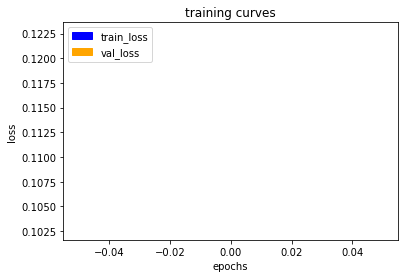

200/200 [==============================] - 193s - loss: 0.1227 - val_loss: 0.1026
Epoch 2/100
199/200 [============================>.] - ETA: 0s - loss: 0.0477

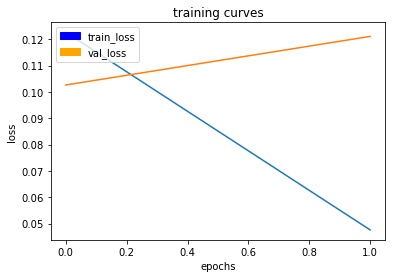

200/200 [==============================] - 188s - loss: 0.0476 - val_loss: 0.1211
Epoch 3/100
199/200 [============================>.] - ETA: 0s - loss: 0.0403

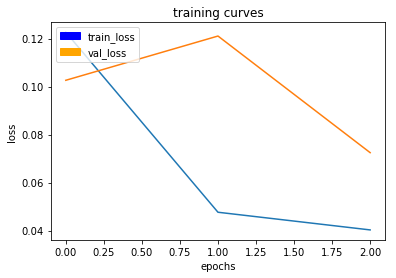

200/200 [==============================] - 189s - loss: 0.0402 - val_loss: 0.0724
Epoch 4/100
199/200 [============================>.] - ETA: 0s - loss: 0.0367

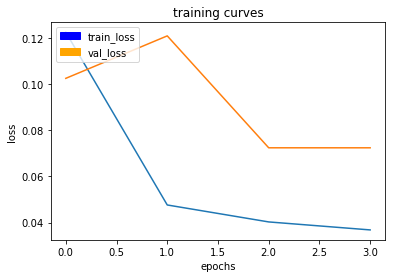

200/200 [==============================] - 188s - loss: 0.0367 - val_loss: 0.0724
Epoch 5/100
199/200 [============================>.] - ETA: 0s - loss: 0.0320

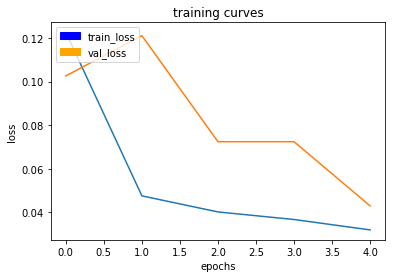

200/200 [==============================] - 189s - loss: 0.0320 - val_loss: 0.0430
Epoch 6/100
199/200 [============================>.] - ETA: 0s - loss: 0.0332

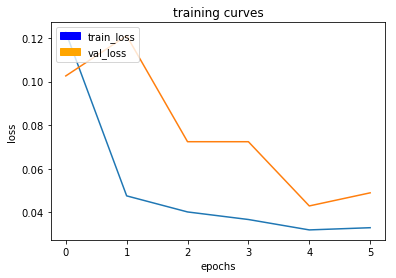

200/200 [==============================] - 188s - loss: 0.0332 - val_loss: 0.0490
Epoch 7/100
199/200 [============================>.] - ETA: 0s - loss: 0.0308

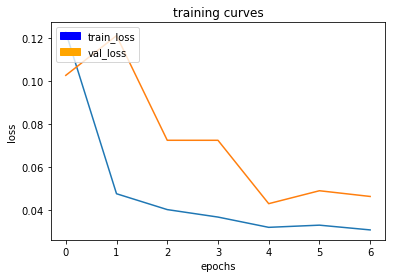

200/200 [==============================] - 189s - loss: 0.0308 - val_loss: 0.0464
Epoch 8/100
199/200 [============================>.] - ETA: 0s - loss: 0.0295

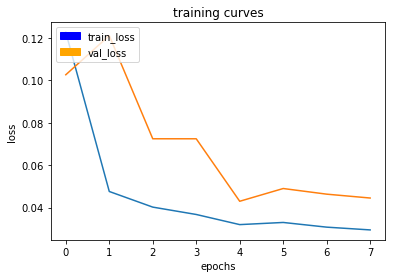

200/200 [==============================] - 188s - loss: 0.0295 - val_loss: 0.0445
Epoch 9/100
199/200 [============================>.] - ETA: 0s - loss: 0.0256

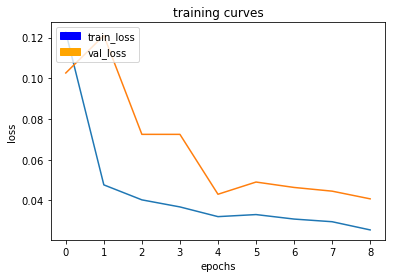

200/200 [==============================] - 188s - loss: 0.0256 - val_loss: 0.0407
Epoch 10/100
199/200 [============================>.] - ETA: 0s - loss: 0.0276

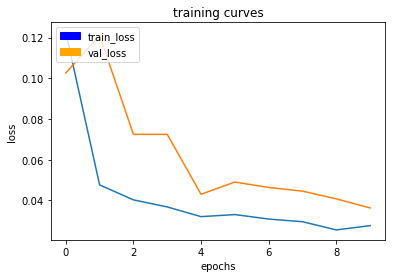

200/200 [==============================] - 189s - loss: 0.0276 - val_loss: 0.0363
Epoch 11/100
199/200 [============================>.] - ETA: 0s - loss: 0.0250

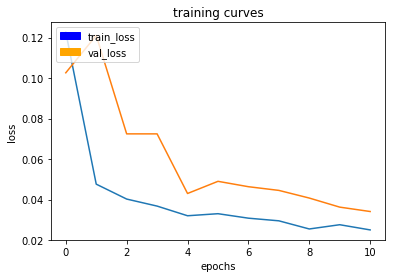

200/200 [==============================] - 189s - loss: 0.0250 - val_loss: 0.0341
Epoch 12/100
199/200 [============================>.] - ETA: 0s - loss: 0.0271

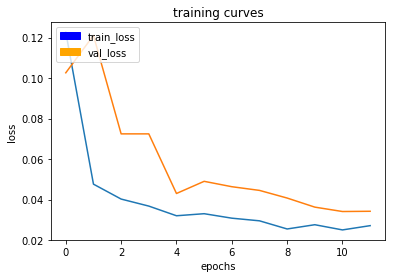

200/200 [==============================] - 188s - loss: 0.0271 - val_loss: 0.0342
Epoch 13/100
199/200 [============================>.] - ETA: 0s - loss: 0.0240

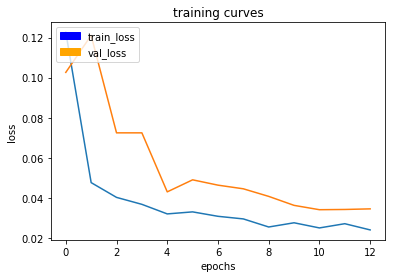

200/200 [==============================] - 188s - loss: 0.0241 - val_loss: 0.0345
Epoch 14/100
199/200 [============================>.] - ETA: 0s - loss: 0.0249

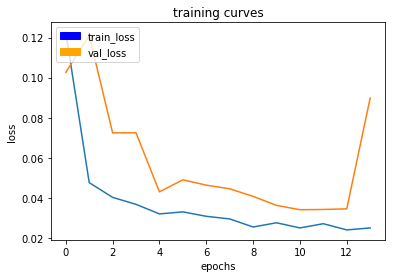

200/200 [==============================] - 189s - loss: 0.0251 - val_loss: 0.0898
Epoch 15/100
199/200 [============================>.] - ETA: 0s - loss: 0.0229

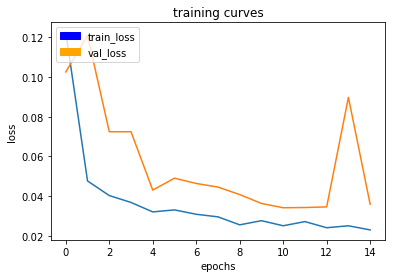

200/200 [==============================] - 189s - loss: 0.0229 - val_loss: 0.0358
Epoch 16/100
199/200 [============================>.] - ETA: 0s - loss: 0.0223

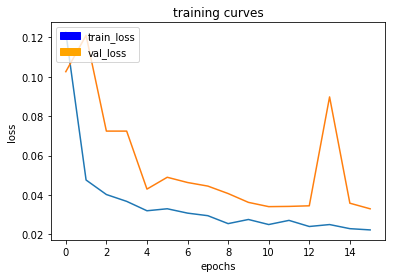

200/200 [==============================] - 189s - loss: 0.0223 - val_loss: 0.0330
Epoch 17/100
199/200 [============================>.] - ETA: 0s - loss: 0.0208

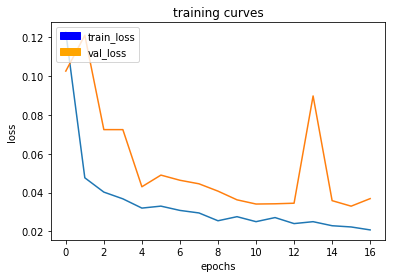

200/200 [==============================] - 188s - loss: 0.0207 - val_loss: 0.0369
Epoch 18/100
199/200 [============================>.] - ETA: 0s - loss: 0.0224

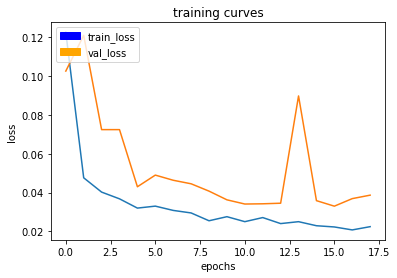

200/200 [==============================] - 189s - loss: 0.0224 - val_loss: 0.0387
Epoch 19/100
199/200 [============================>.] - ETA: 0s - loss: 0.0217

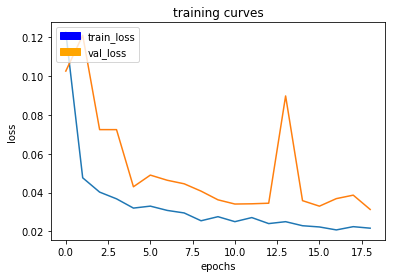

200/200 [==============================] - 188s - loss: 0.0217 - val_loss: 0.0313
Epoch 20/100
199/200 [============================>.] - ETA: 0s - loss: 0.0200

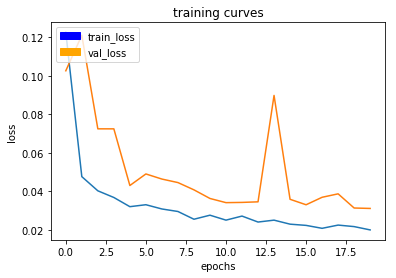

200/200 [==============================] - 190s - loss: 0.0200 - val_loss: 0.0311
Epoch 21/100
199/200 [============================>.] - ETA: 0s - loss: 0.0208

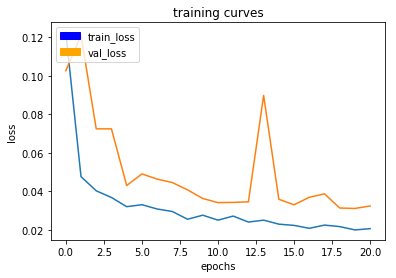

200/200 [==============================] - 189s - loss: 0.0208 - val_loss: 0.0324
Epoch 22/100
199/200 [============================>.] - ETA: 0s - loss: 0.0203

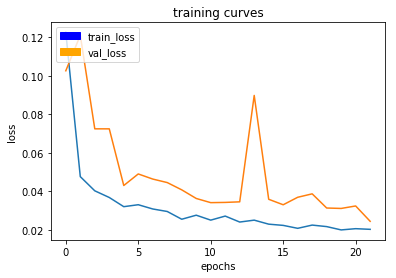

200/200 [==============================] - 190s - loss: 0.0203 - val_loss: 0.0244
Epoch 23/100
199/200 [============================>.] - ETA: 0s - loss: 0.0188

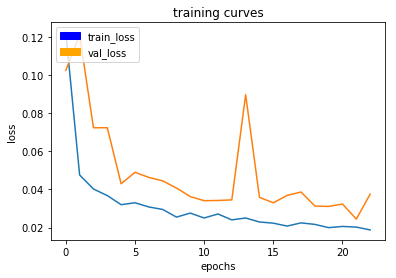

200/200 [==============================] - 188s - loss: 0.0188 - val_loss: 0.0376
Epoch 24/100
199/200 [============================>.] - ETA: 0s - loss: 0.0211

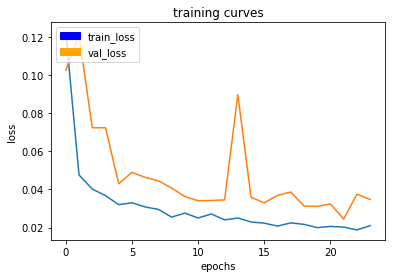

200/200 [==============================] - 189s - loss: 0.0210 - val_loss: 0.0348
Epoch 25/100
199/200 [============================>.] - ETA: 0s - loss: 0.0194

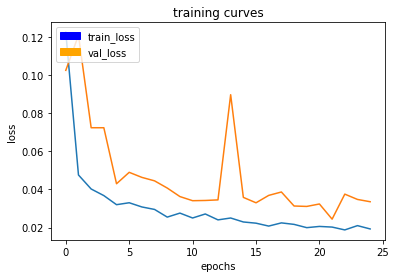

200/200 [==============================] - 188s - loss: 0.0194 - val_loss: 0.0336
Epoch 26/100
199/200 [============================>.] - ETA: 0s - loss: 0.0187

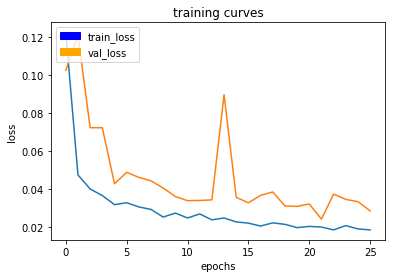

200/200 [==============================] - 188s - loss: 0.0187 - val_loss: 0.0288
Epoch 27/100
199/200 [============================>.] - ETA: 0s - loss: 0.0179

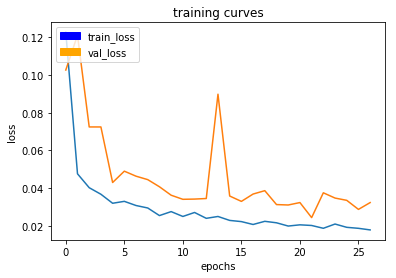

200/200 [==============================] - 189s - loss: 0.0179 - val_loss: 0.0324
Epoch 28/100
199/200 [============================>.] - ETA: 0s - loss: 0.0216

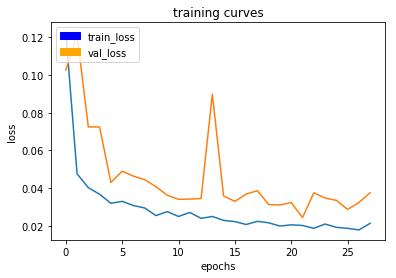

200/200 [==============================] - 188s - loss: 0.0216 - val_loss: 0.0376
Epoch 29/100
199/200 [============================>.] - ETA: 0s - loss: 0.0189

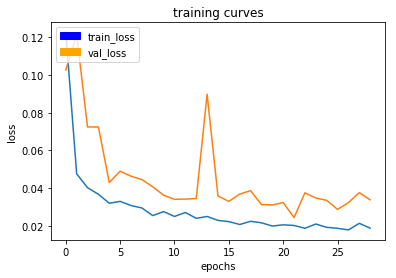

200/200 [==============================] - 189s - loss: 0.0189 - val_loss: 0.0338
Epoch 30/100
199/200 [============================>.] - ETA: 0s - loss: 0.0186

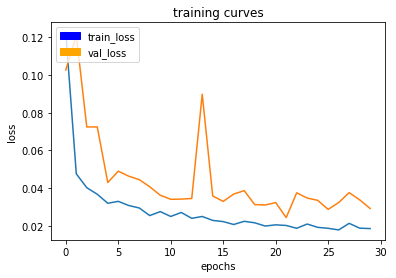

200/200 [==============================] - 188s - loss: 0.0186 - val_loss: 0.0292
Epoch 31/100
199/200 [============================>.] - ETA: 0s - loss: 0.0167

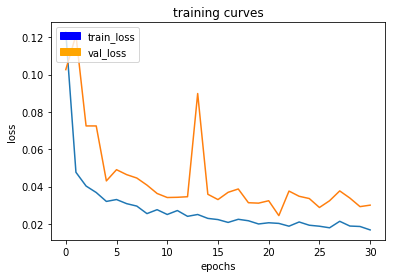

200/200 [==============================] - 189s - loss: 0.0167 - val_loss: 0.0300
Epoch 32/100
199/200 [============================>.] - ETA: 0s - loss: 0.0179

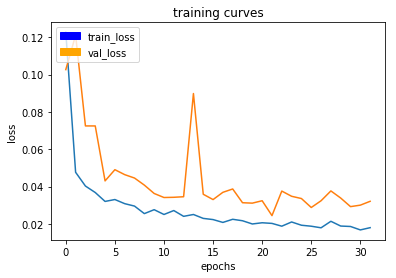

200/200 [==============================] - 188s - loss: 0.0180 - val_loss: 0.0321
Epoch 33/100
199/200 [============================>.] - ETA: 0s - loss: 0.0169

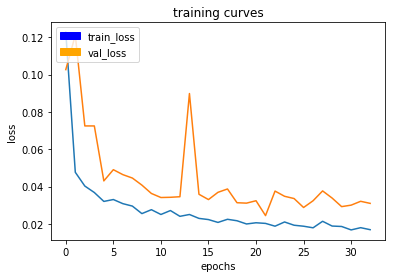

200/200 [==============================] - 189s - loss: 0.0169 - val_loss: 0.0310
Epoch 34/100
199/200 [============================>.] - ETA: 0s - loss: 0.0162

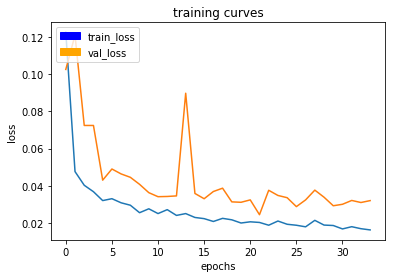

200/200 [==============================] - 188s - loss: 0.0162 - val_loss: 0.0320
Epoch 35/100
199/200 [============================>.] - ETA: 0s - loss: 0.0178

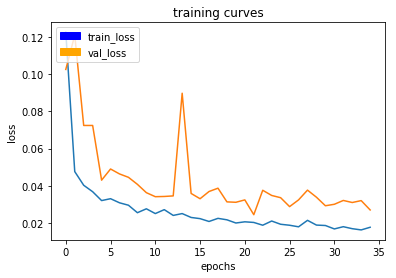

200/200 [==============================] - 189s - loss: 0.0177 - val_loss: 0.0270
Epoch 36/100
199/200 [============================>.] - ETA: 0s - loss: 0.0170

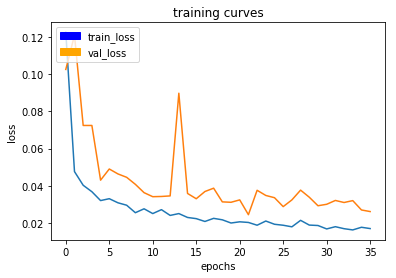

200/200 [==============================] - 188s - loss: 0.0170 - val_loss: 0.0261
Epoch 37/100
199/200 [============================>.] - ETA: 0s - loss: 0.0157

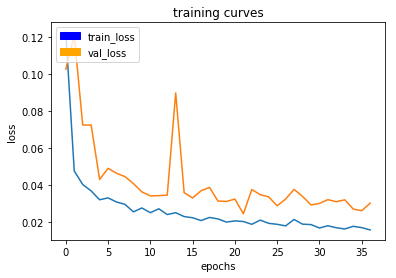

200/200 [==============================] - 189s - loss: 0.0157 - val_loss: 0.0302
Epoch 38/100
199/200 [============================>.] - ETA: 0s - loss: 0.0155

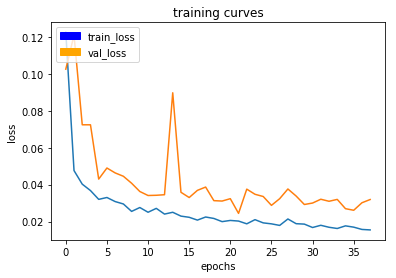

200/200 [==============================] - 188s - loss: 0.0155 - val_loss: 0.0319
Epoch 39/100
199/200 [============================>.] - ETA: 0s - loss: 0.0155

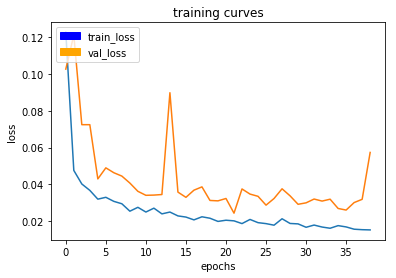

200/200 [==============================] - 188s - loss: 0.0155 - val_loss: 0.0574
Epoch 40/100
199/200 [============================>.] - ETA: 0s - loss: 0.0349

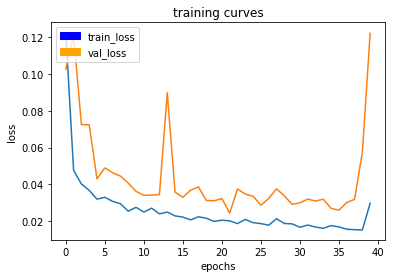

200/200 [==============================] - 189s - loss: 0.0349 - val_loss: 0.1221
Epoch 41/100
199/200 [============================>.] - ETA: 0s - loss: 0.0359

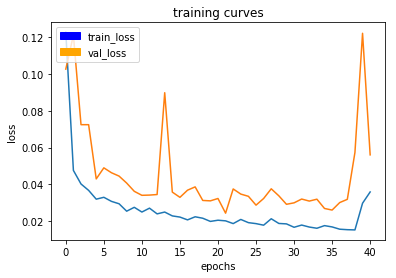

200/200 [==============================] - 188s - loss: 0.0358 - val_loss: 0.0561
Epoch 42/100
199/200 [============================>.] - ETA: 0s - loss: 0.0289

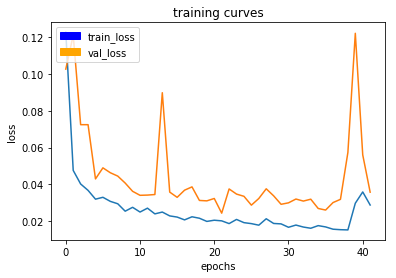

200/200 [==============================] - 189s - loss: 0.0288 - val_loss: 0.0358
Epoch 43/100
199/200 [============================>.] - ETA: 0s - loss: 0.0256

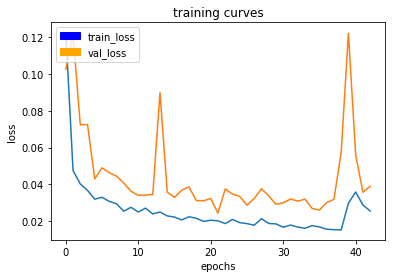

200/200 [==============================] - 188s - loss: 0.0256 - val_loss: 0.0390
Epoch 44/100
199/200 [============================>.] - ETA: 0s - loss: 0.0241

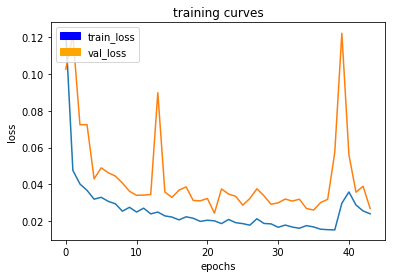

200/200 [==============================] - 189s - loss: 0.0241 - val_loss: 0.0269
Epoch 45/100
199/200 [============================>.] - ETA: 0s - loss: 0.0212

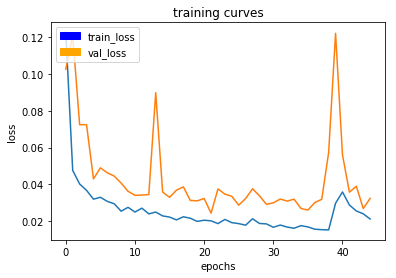

200/200 [==============================] - 188s - loss: 0.0212 - val_loss: 0.0324
Epoch 46/100
199/200 [============================>.] - ETA: 0s - loss: 0.0210

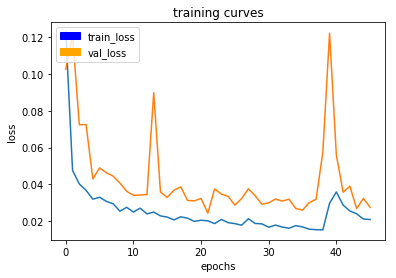

200/200 [==============================] - 189s - loss: 0.0209 - val_loss: 0.0275
Epoch 47/100
199/200 [============================>.] - ETA: 0s - loss: 0.0197

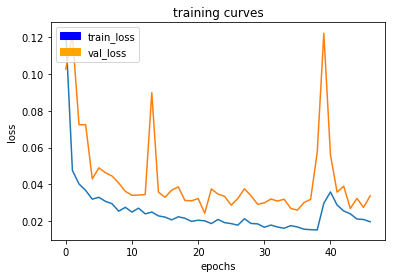

200/200 [==============================] - 189s - loss: 0.0197 - val_loss: 0.0338
Epoch 48/100
199/200 [============================>.] - ETA: 0s - loss: 0.0192

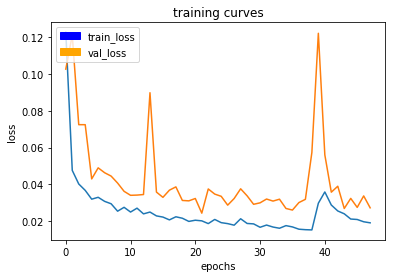

200/200 [==============================] - 189s - loss: 0.0192 - val_loss: 0.0273
Epoch 49/100
199/200 [============================>.] - ETA: 0s - loss: 0.0212

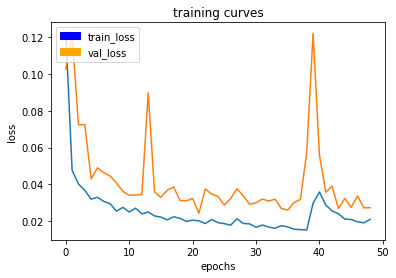

200/200 [==============================] - 188s - loss: 0.0211 - val_loss: 0.0274
Epoch 50/100
199/200 [============================>.] - ETA: 0s - loss: 0.0182

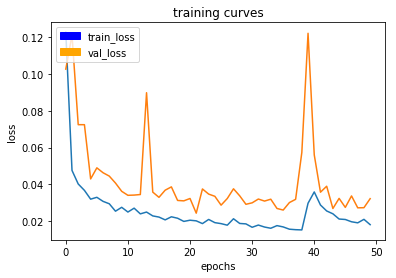

200/200 [==============================] - 189s - loss: 0.0181 - val_loss: 0.0323
Epoch 51/100
199/200 [============================>.] - ETA: 0s - loss: 0.0182

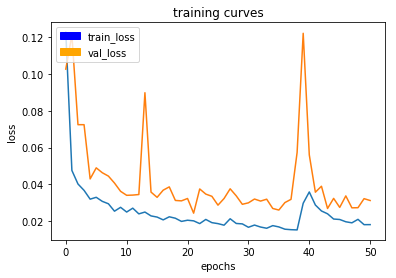

200/200 [==============================] - 188s - loss: 0.0182 - val_loss: 0.0313
Epoch 52/100
199/200 [============================>.] - ETA: 0s - loss: 0.0186

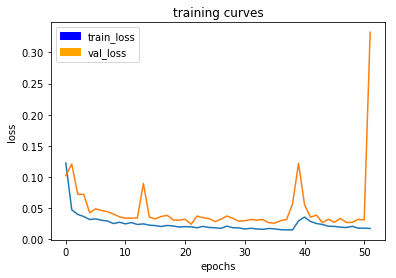

200/200 [==============================] - 188s - loss: 0.0187 - val_loss: 0.3324
Epoch 53/100
199/200 [============================>.] - ETA: 0s - loss: 0.0223

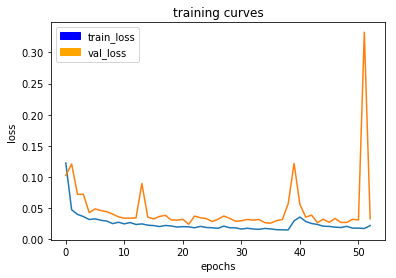

200/200 [==============================] - 189s - loss: 0.0223 - val_loss: 0.0332
Epoch 54/100
199/200 [============================>.] - ETA: 0s - loss: 0.0179

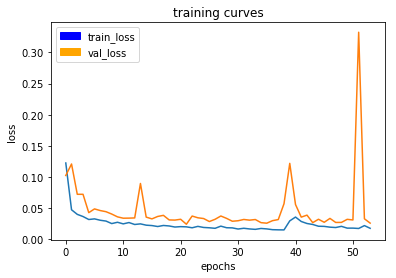

200/200 [==============================] - 188s - loss: 0.0179 - val_loss: 0.0262
Epoch 55/100
199/200 [============================>.] - ETA: 0s - loss: 0.0163

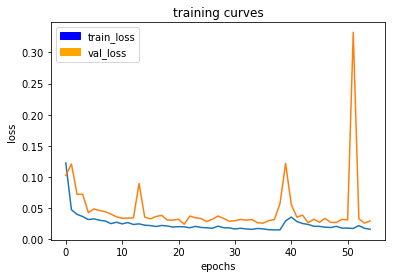

200/200 [==============================] - 188s - loss: 0.0163 - val_loss: 0.0298
Epoch 56/100
199/200 [============================>.] - ETA: 0s - loss: 0.0180

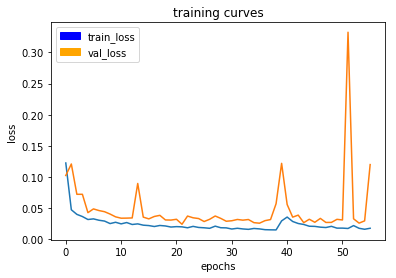

200/200 [==============================] - 188s - loss: 0.0180 - val_loss: 0.1201
Epoch 57/100
199/200 [============================>.] - ETA: 0s - loss: 0.0176

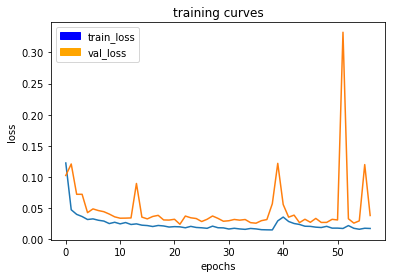

200/200 [==============================] - 189s - loss: 0.0176 - val_loss: 0.0384
Epoch 58/100
199/200 [============================>.] - ETA: 0s - loss: 0.0170

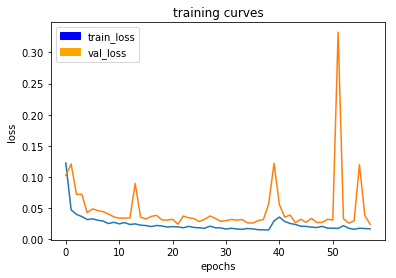

200/200 [==============================] - 188s - loss: 0.0170 - val_loss: 0.0242
Epoch 59/100
199/200 [============================>.] - ETA: 0s - loss: 0.0160

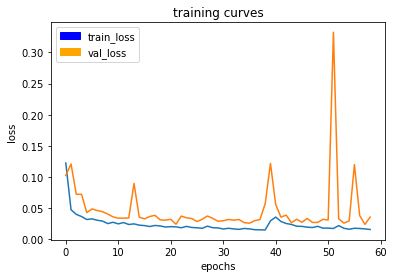

200/200 [==============================] - 188s - loss: 0.0160 - val_loss: 0.0359
Epoch 60/100
199/200 [============================>.] - ETA: 0s - loss: 0.0156

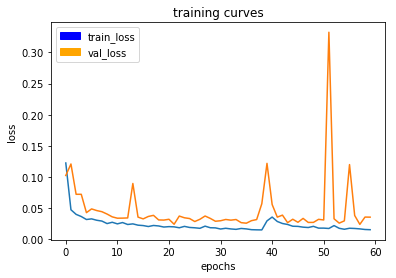

200/200 [==============================] - 187s - loss: 0.0156 - val_loss: 0.0358
Epoch 61/100
199/200 [============================>.] - ETA: 0s - loss: 0.0160

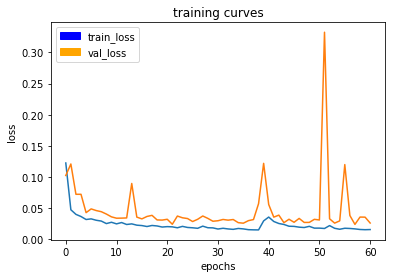

200/200 [==============================] - 189s - loss: 0.0159 - val_loss: 0.0264
Epoch 62/100
199/200 [============================>.] - ETA: 0s - loss: 0.0140

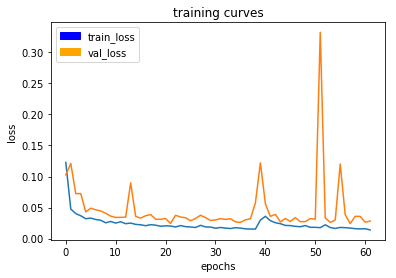

200/200 [==============================] - 188s - loss: 0.0140 - val_loss: 0.0283
Epoch 63/100
199/200 [============================>.] - ETA: 0s - loss: 0.0167

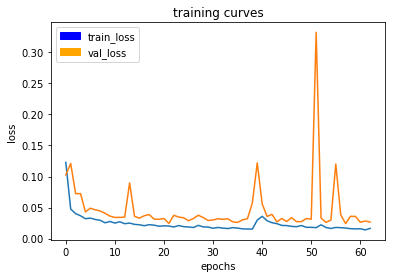

200/200 [==============================] - 188s - loss: 0.0166 - val_loss: 0.0267
Epoch 64/100
199/200 [============================>.] - ETA: 0s - loss: 0.0164

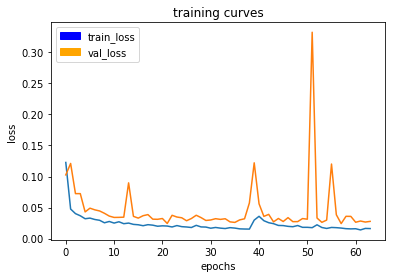

200/200 [==============================] - 188s - loss: 0.0164 - val_loss: 0.0278
Epoch 65/100
199/200 [============================>.] - ETA: 0s - loss: 0.0148

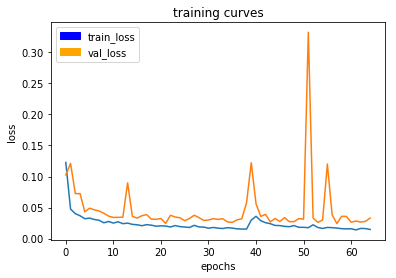

200/200 [==============================] - 188s - loss: 0.0148 - val_loss: 0.0331
Epoch 66/100
199/200 [============================>.] - ETA: 0s - loss: 0.0139

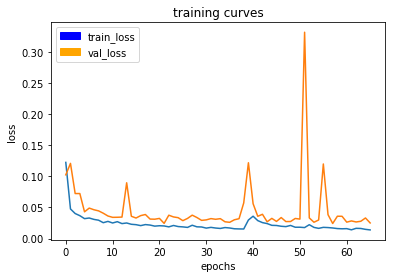

200/200 [==============================] - 188s - loss: 0.0138 - val_loss: 0.0251
Epoch 67/100
199/200 [============================>.] - ETA: 0s - loss: 0.0149

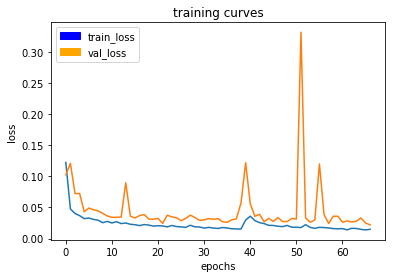

200/200 [==============================] - 187s - loss: 0.0149 - val_loss: 0.0219
Epoch 68/100
199/200 [============================>.] - ETA: 0s - loss: 0.0144

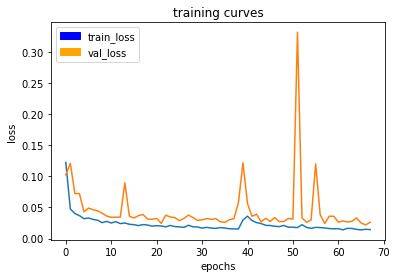

200/200 [==============================] - 189s - loss: 0.0144 - val_loss: 0.0261
Epoch 69/100
199/200 [============================>.] - ETA: 0s - loss: 0.0150

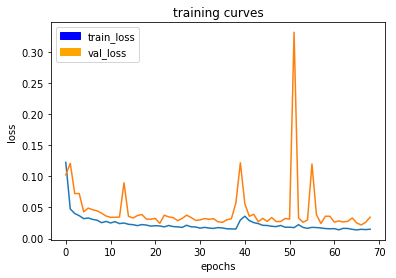

200/200 [==============================] - 188s - loss: 0.0150 - val_loss: 0.0344
Epoch 70/100
199/200 [============================>.] - ETA: 0s - loss: 0.0144

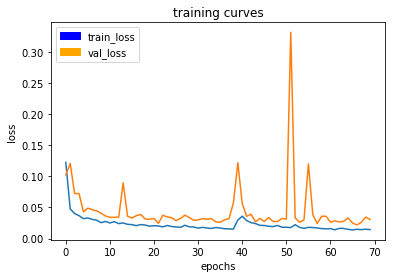

200/200 [==============================] - 188s - loss: 0.0144 - val_loss: 0.0307
Epoch 71/100
199/200 [============================>.] - ETA: 0s - loss: 0.0129

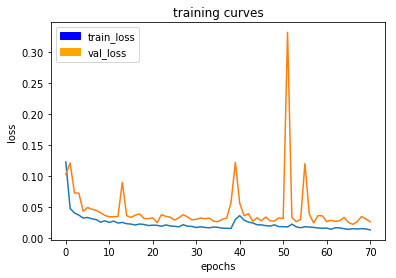

200/200 [==============================] - 188s - loss: 0.0129 - val_loss: 0.0260
Epoch 72/100
199/200 [============================>.] - ETA: 0s - loss: 0.0128

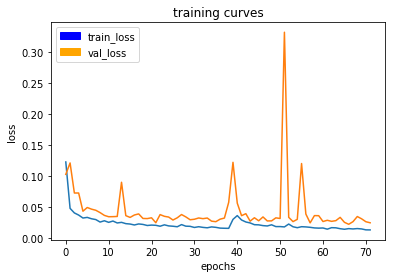

200/200 [==============================] - 188s - loss: 0.0128 - val_loss: 0.0243
Epoch 73/100
199/200 [============================>.] - ETA: 0s - loss: 0.0141

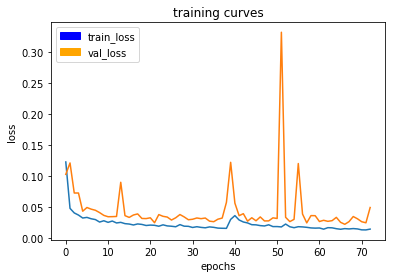

200/200 [==============================] - 188s - loss: 0.0141 - val_loss: 0.0490
Epoch 74/100
199/200 [============================>.] - ETA: 0s - loss: 0.0134

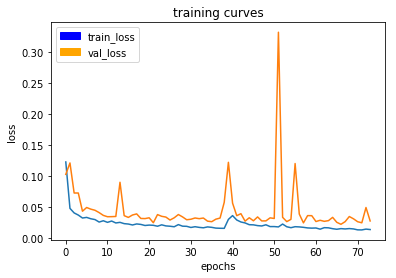

200/200 [==============================] - 188s - loss: 0.0134 - val_loss: 0.0272
Epoch 75/100
199/200 [============================>.] - ETA: 0s - loss: 0.0138

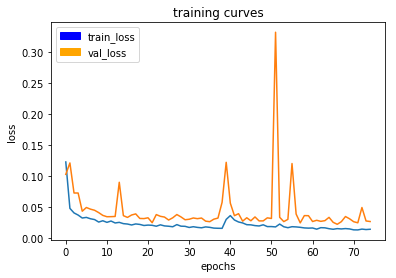

200/200 [==============================] - 188s - loss: 0.0138 - val_loss: 0.0263
Epoch 76/100
199/200 [============================>.] - ETA: 0s - loss: 0.0123

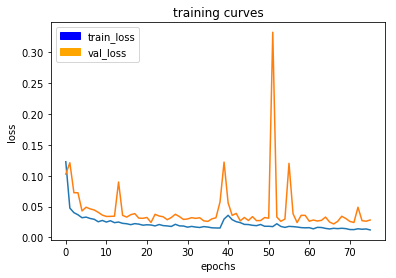

200/200 [==============================] - 189s - loss: 0.0123 - val_loss: 0.0283
Epoch 77/100
199/200 [============================>.] - ETA: 0s - loss: 0.0135

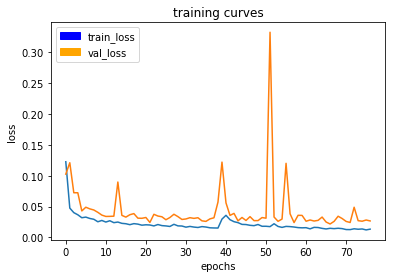

200/200 [==============================] - 188s - loss: 0.0135 - val_loss: 0.0268
Epoch 78/100
199/200 [============================>.] - ETA: 0s - loss: 0.0135

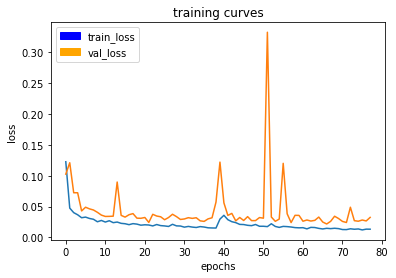

200/200 [==============================] - 188s - loss: 0.0135 - val_loss: 0.0325
Epoch 79/100
199/200 [============================>.] - ETA: 0s - loss: 0.0144

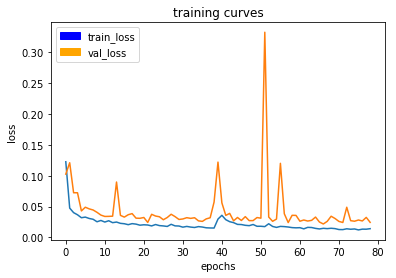

200/200 [==============================] - 189s - loss: 0.0144 - val_loss: 0.0245
Epoch 80/100
199/200 [============================>.] - ETA: 0s - loss: 0.0122

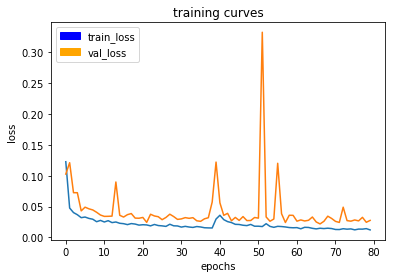

200/200 [==============================] - 188s - loss: 0.0122 - val_loss: 0.0276
Epoch 81/100
199/200 [============================>.] - ETA: 0s - loss: 0.0126

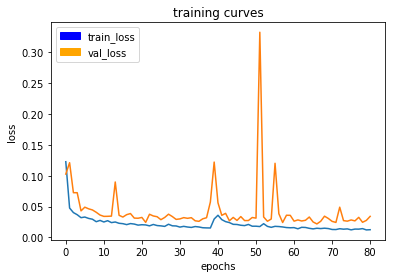

200/200 [==============================] - 189s - loss: 0.0126 - val_loss: 0.0341
Epoch 82/100
199/200 [============================>.] - ETA: 0s - loss: 0.0118

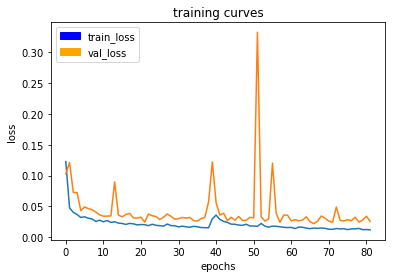

200/200 [==============================] - 187s - loss: 0.0118 - val_loss: 0.0255
Epoch 83/100
199/200 [============================>.] - ETA: 0s - loss: 0.0125

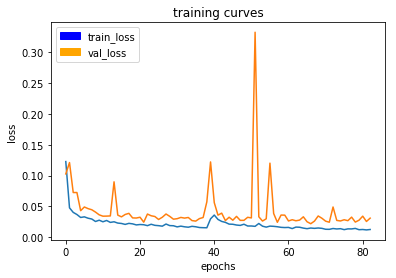

200/200 [==============================] - 189s - loss: 0.0125 - val_loss: 0.0309
Epoch 84/100
199/200 [============================>.] - ETA: 0s - loss: 0.0130

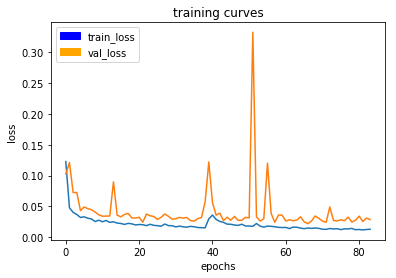

200/200 [==============================] - 187s - loss: 0.0130 - val_loss: 0.0287
Epoch 85/100
199/200 [============================>.] - ETA: 0s - loss: 0.0122

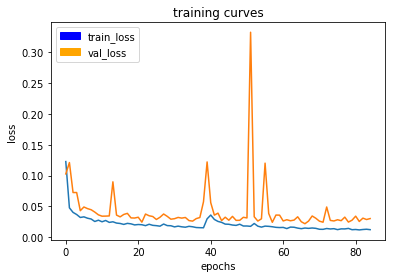

200/200 [==============================] - 188s - loss: 0.0122 - val_loss: 0.0302
Epoch 86/100
199/200 [============================>.] - ETA: 0s - loss: 0.0124

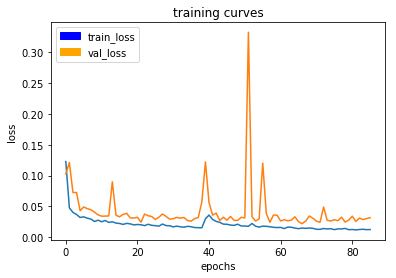

200/200 [==============================] - 188s - loss: 0.0125 - val_loss: 0.0317
Epoch 87/100
199/200 [============================>.] - ETA: 0s - loss: 0.0118

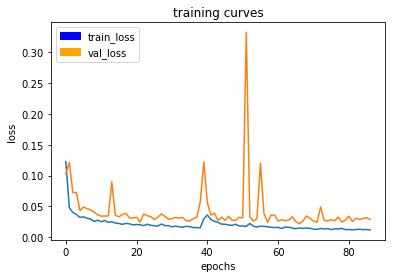

200/200 [==============================] - 188s - loss: 0.0118 - val_loss: 0.0287
Epoch 88/100
199/200 [============================>.] - ETA: 0s - loss: 0.0117

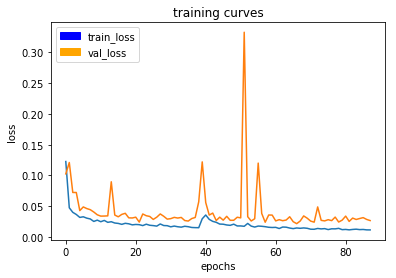

200/200 [==============================] - 188s - loss: 0.0117 - val_loss: 0.0269
Epoch 89/100
199/200 [============================>.] - ETA: 0s - loss: 0.0127

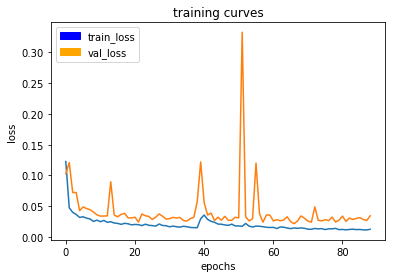

200/200 [==============================] - 188s - loss: 0.0127 - val_loss: 0.0346
Epoch 90/100
199/200 [============================>.] - ETA: 0s - loss: 0.0123

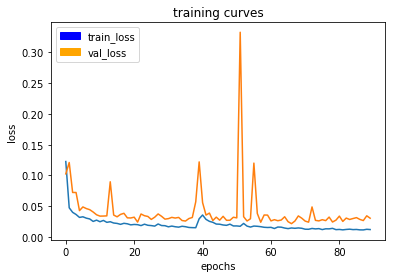

200/200 [==============================] - 188s - loss: 0.0123 - val_loss: 0.0307
Epoch 91/100
199/200 [============================>.] - ETA: 0s - loss: 0.0112

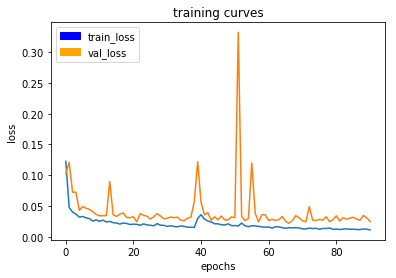

200/200 [==============================] - 188s - loss: 0.0112 - val_loss: 0.0249
Epoch 92/100
199/200 [============================>.] - ETA: 0s - loss: 0.0115

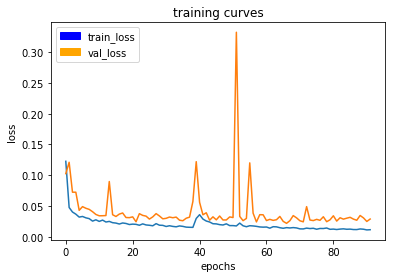

200/200 [==============================] - 188s - loss: 0.0115 - val_loss: 0.0289
Epoch 93/100
199/200 [============================>.] - ETA: 0s - loss: 0.0128

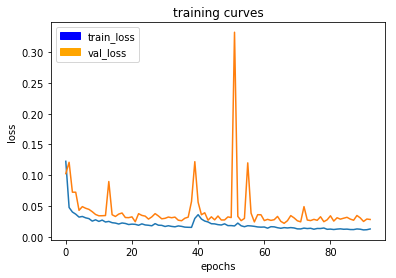

200/200 [==============================] - 188s - loss: 0.0128 - val_loss: 0.0281
Epoch 94/100
199/200 [============================>.] - ETA: 0s - loss: 0.0115

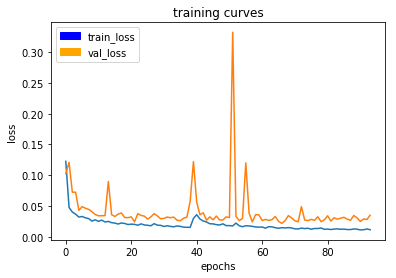

200/200 [==============================] - 189s - loss: 0.0115 - val_loss: 0.0350
Epoch 95/100
199/200 [============================>.] - ETA: 0s - loss: 0.0120

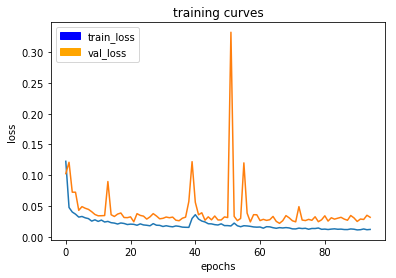

200/200 [==============================] - 187s - loss: 0.0120 - val_loss: 0.0317
Epoch 96/100
199/200 [============================>.] - ETA: 0s - loss: 0.0111

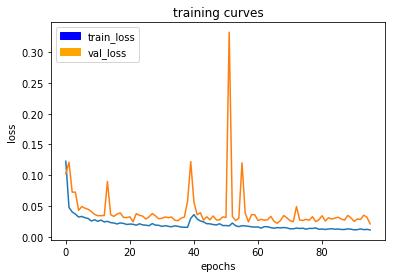

200/200 [==============================] - 188s - loss: 0.0111 - val_loss: 0.0208
Epoch 97/100
199/200 [============================>.] - ETA: 0s - loss: 0.0120

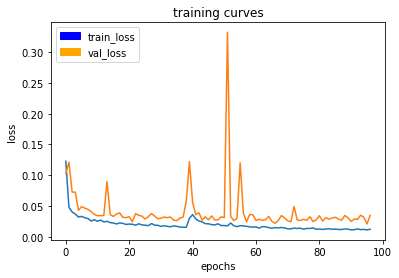

200/200 [==============================] - 188s - loss: 0.0121 - val_loss: 0.0346
Epoch 98/100
199/200 [============================>.] - ETA: 0s - loss: 0.0139

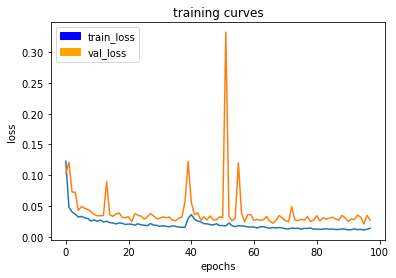

200/200 [==============================] - 189s - loss: 0.0139 - val_loss: 0.0270
Epoch 99/100
199/200 [============================>.] - ETA: 0s - loss: 0.0120

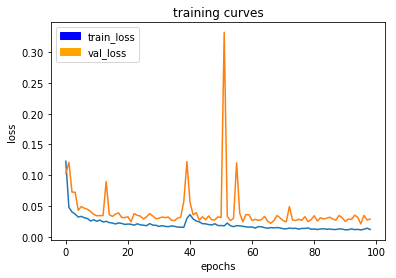

200/200 [==============================] - 188s - loss: 0.0120 - val_loss: 0.0287
Epoch 100/100
199/200 [============================>.] - ETA: 0s - loss: 0.0114

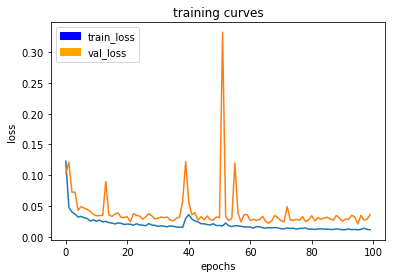

200/200 [==============================] - 189s - loss: 0.0114 - val_loss: 0.0358


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

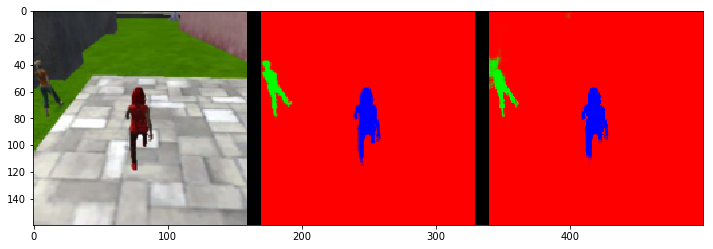

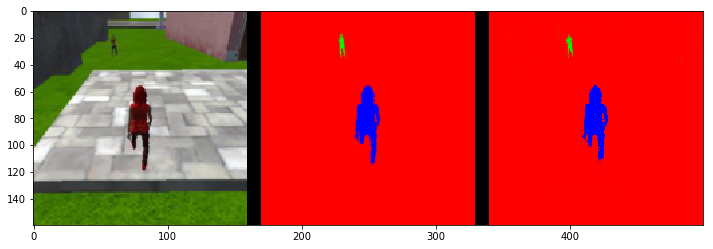

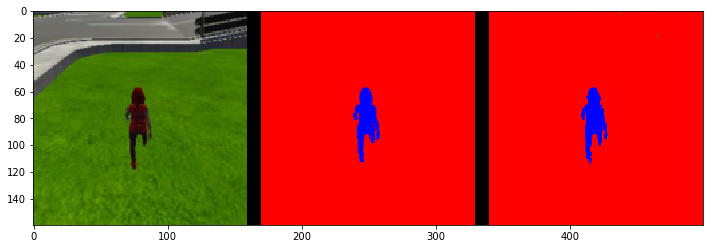

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

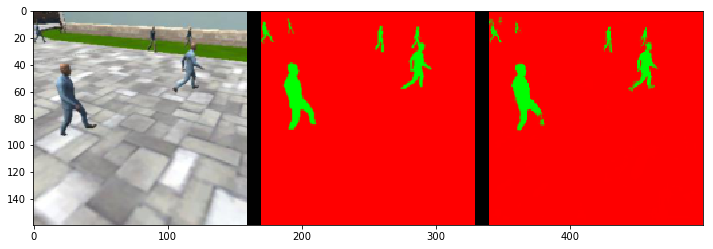

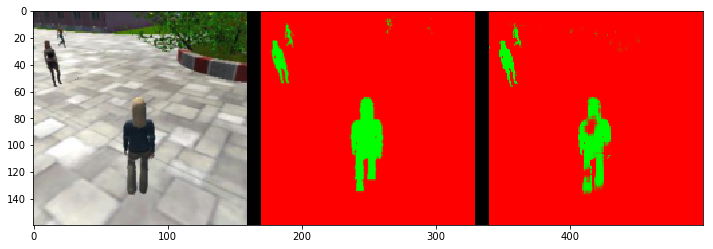

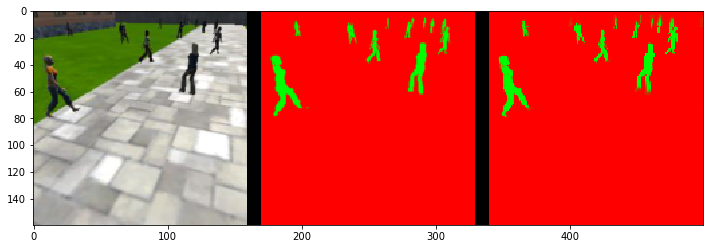

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

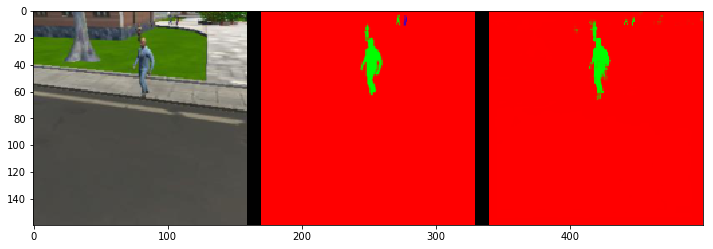

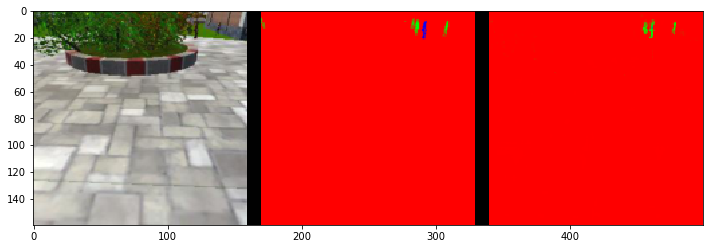

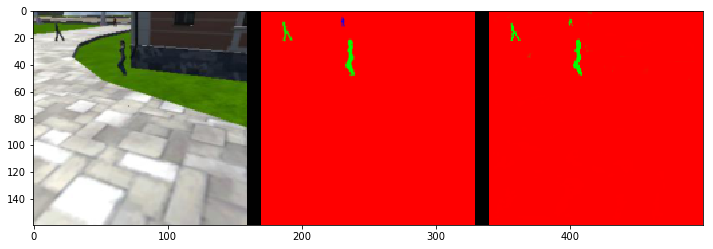

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9961206555811885
average intersection over union for other people is 0.38835737148383404
average intersection over union for the hero is 0.9089918724463325
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9861477913391394
average intersection over union for other people is 0.718381939051623
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 67, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.996636802701788
average intersection over union for other people is 0.4693363081257744
average intersection over union for the hero is 0.24404299254824302
number true positives: 140, number false positives: 2, number false negatives: 161


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.746974697469747


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.576517432497


In [2]:
# And the final grade score is 
final_IoU = 0.576517432497
weight = 0.746974697469747

# Sorry for missing process last cell during training kernal on AWS.
# I manually copy and paste output from last two cells.
final_score = final_IoU * weight
print(final_score)

0.4306439347254819
